<a href="https://colab.research.google.com/github/navkiran/Machine_Learning/blob/master/COE17_101703365_Navkiran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Categorical Features Encoding Dataset](https://www.kaggle.com/c/cat-in-the-dat/overview) 

**Navkiran Singh**

**Roll Number:** 101703365

**Group:** COE17

Kaggle username: navkirantu 

Kaggle Email: nsingh2_be17@thapar.edu

Contact: 9988477504

### Final Kaggle Score

Using MLP with 2 hidden layers (512 neurons, 32 neurons) and early stopping. Batch_size = 32, epochs = 100.

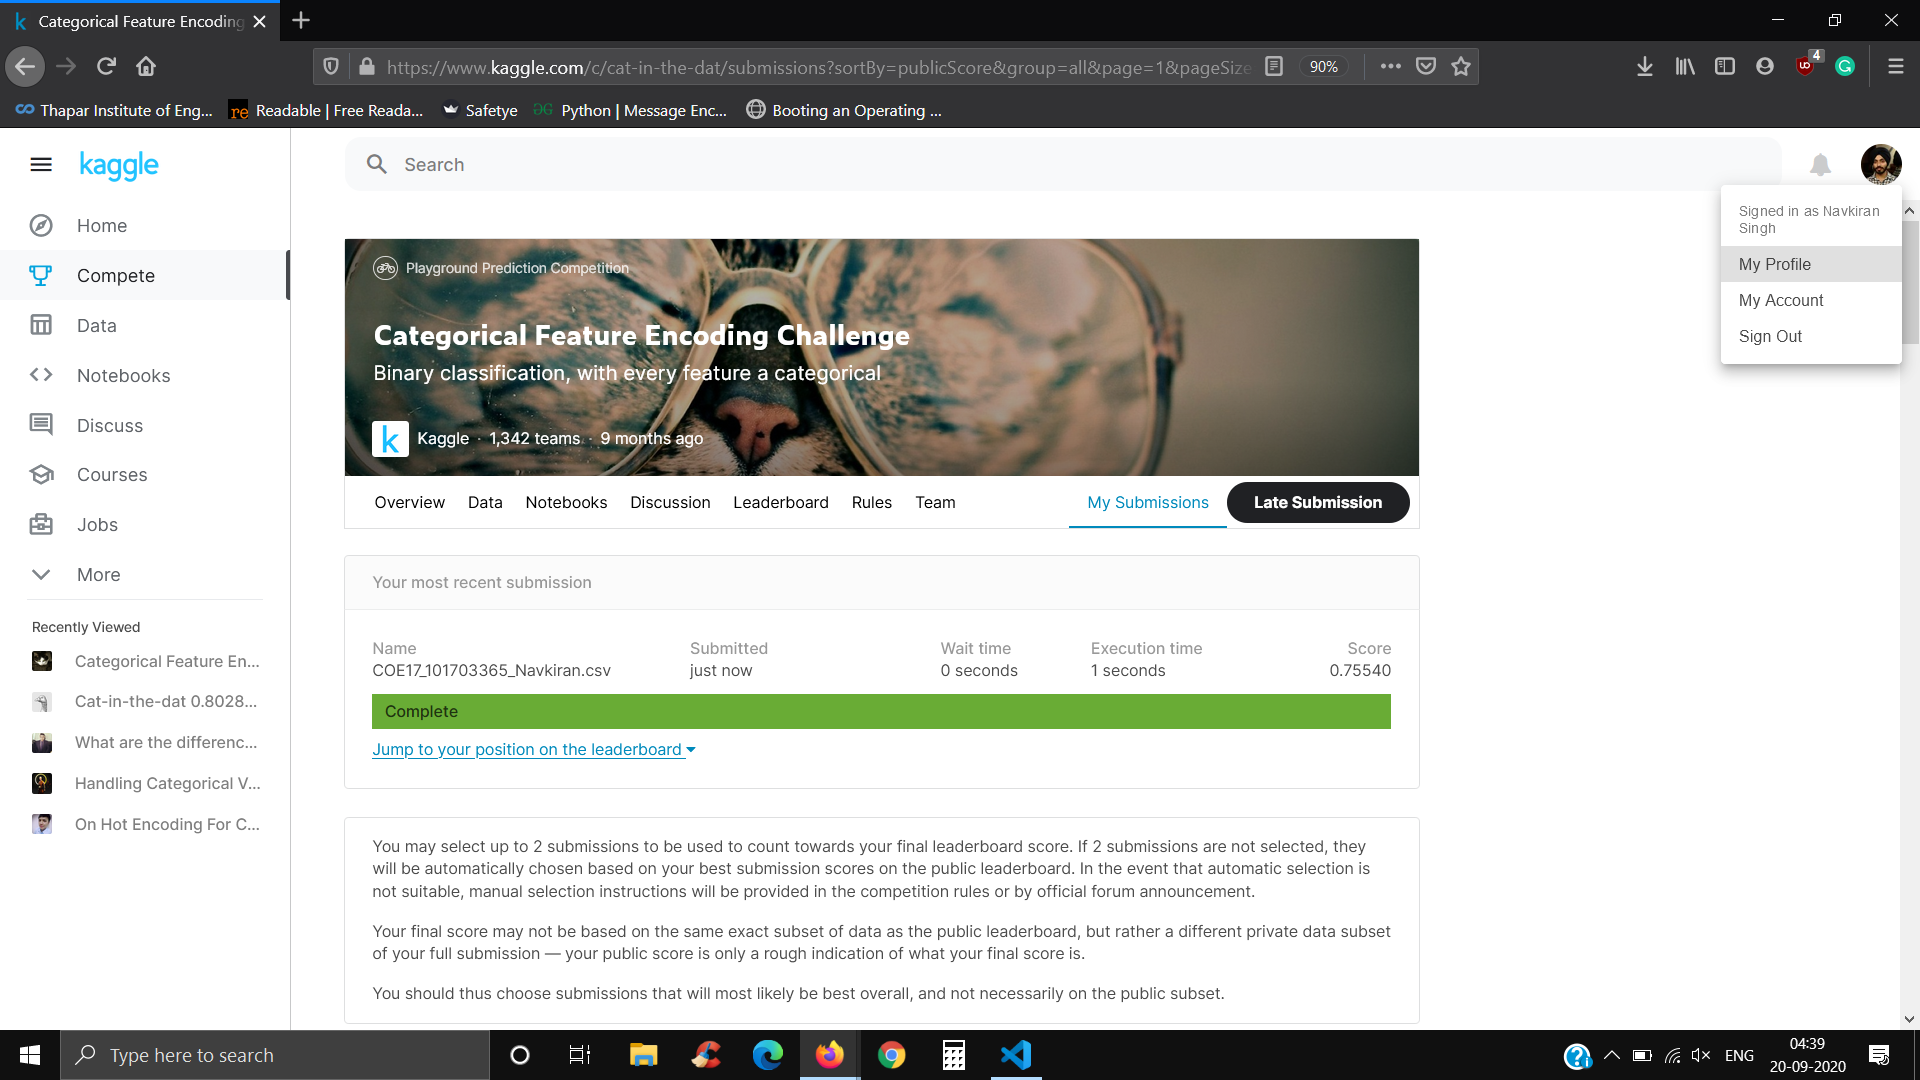

### **The organisation of this pdf is as follows:**

- Code snippets of connecting kaggle to colab
- Date Preprocessing code snippets
  - loading data
  - encoding categorical features using different techniques
  - creating X_train, y_train, X_test for model training
- MLP models code snippets
 - Using Early Stopping
 - And saving best model using model checkpoints

- code snippet for submission to kaggle

- [Link to the Colab notebook](https://colab.research.google.com/drive/1Y8-kpiMSqX04yz6d3dzB_bVFmkM3GX7v?usp=sharing)
 - Link is editable and runnable
 - But loading data from Kaggle requires uploading api-token before proceeding

## Downloading Kaggle Data in Google Colab

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"navkirantu","key":"e7352003d954712ab962a0cdb5e740f5"}'}

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c cat-in-the-dat

 60% 5.00M/8.28M [00:00<00:00, 32.0MB/s]
100% 8.28M/8.28M [00:00<00:00, 40.4MB/s]
  0% 0.00/436k [00:00<?, ?B/s]
100% 436k/436k [00:00<00:00, 137MB/s]
 72% 9.00M/12.5M [00:00<00:00, 33.2MB/s]
100% 12.5M/12.5M [00:00<00:00, 41.5MB/s]


In [6]:
!unzip /content/train.csv.zip -d train

Archive:  /content/train.csv.zip
  inflating: train/train.csv         


In [7]:
!unzip /content/test.csv.zip -d test

Archive:  /content/test.csv.zip
  inflating: test/test.csv           


In [8]:
!unzip /content/sample_submission.csv.zip -d submission

Archive:  /content/sample_submission.csv.zip
  inflating: submission/sample_submission.csv  


## Data Preprocessing

In [9]:
import pandas as pd
import numpy as np

In [10]:
train = pd.read_csv('/content/train/train.csv')
test = pd.read_csv('/content/test/test.csv')
submission=pd.read_csv('/content/submission/sample_submission.csv', index_col='id')
print(f'The train data shape is: {train.shape}\nThe test data shape is: {test.shape}')

The train data shape is: (300000, 25)
The test data shape is: (200000, 24)


In [11]:
target = train.pop('target')
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
print(f'The train data shape is: {train.shape}\nThe test data shape is: {test.shape}')

The train data shape is: (300000, 23)
The test data shape is: (200000, 23)


#### Please refer below for overview of types of columns.

There are different types of categorical features present. 

Before applying a machine learning model, these features must be appropriately encoded to numerical values.

**Types of Categorical Features Present:**

1. Binary Features
2. Nominal Features (Without relative ordering)
3. Ordinal Features (With relative ordering)

There are also day and month columns where values repeat in a cycle.

**Approach:**
1. nom_0 to nom_4 are nominal features (without relative ordering) so they should be One Hot Encoded. Here, get_dummies method is used for one hot encoding.

2. nom_5 to nom_9 have high *cardinality (number of distinct values a column can take)* so if one hot encoding is done, it will add a lot of dummy columns. Instead I am using label encoding here.

*For binary features and ordinal features with low cardinality, I created a function to replace the text labels with appropriate relative ordering.*

3. bin_3 and bin_4 can be directly mapped to 0 (corresponding to F) and 1 (corresponding to T).

4. ord_0 has numerical values. ord_1 to ord_4 have human understandable labels and low cardinality, I have encoded them manually.

5. ord_5 has high cardinality and is ascii strings. I have used OrdinalEncoder with categories set to auto from sklearn.preprocessing. Since the result is an ndarray, this is done at last because I had to perform some further preprocessing through dataframe functions.

6. Using Kaggle and Internet as a reference, I have also encoded cyclical features of day and month by creating sin and cos columns.

In [12]:
train.head(3)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2


### Encoding

First, the number of unique values of each feature is found to get an idea of cardinality. **cardinality** refers to the number of possible values that a feature can assume. Running the below code we find which features have high cardinality (high number of possible values to take) and which have low cardinality.

In [13]:
for col in train.columns[1:-2]:
    print(col, train[col].nunique())

bin_1 2
bin_2 2
bin_3 2
bin_4 2
nom_0 3
nom_1 6
nom_2 6
nom_3 6
nom_4 4
nom_5 222
nom_6 522
nom_7 1220
nom_8 2215
nom_9 11981
ord_0 3
ord_1 5
ord_2 6
ord_3 15
ord_4 26
ord_5 192


nom_5 to nom_9 are high cardinality. ord_5 also has high cardinality.

Binary features and some ordinal features (ord_1 to ord_4) can be manually encoded according to their relative ordering.

The below function takes the text values and replaces them with corresponding numeric values.

In [14]:
def manual_encode(train_col,test_col,to_replace,replace_with):
  train_col.replace(to_replace = to_replace, value = replace_with, inplace = True)
  test_col.replace(to_replace = to_replace, value = replace_with, inplace = True)

In [15]:
manual_encode(train.bin_3,test.bin_3,
                     ['T','F'],
                     [1,0])
manual_encode(train.bin_4,test.bin_4,
                     ['Y','N'],
                     [1,0])

In [16]:
manual_encode(train.ord_1,test.ord_1,
              ['Novice', 'Contributor','Expert', 'Master', 'Grandmaster'],
              [0, 1, 2, 3, 4])
manual_encode(train.ord_2,test.ord_2,
              ['Freezing', 'Cold', 'Warm', 'Hot','Boiling Hot', 'Lava Hot'],
              [0, 1, 2, 3, 4, 5])
manual_encode(train.ord_3,test.ord_3,
              ['a', 'b', 'c', 'd', 'e', 'f', 'g','h', 'i', 'j', 'k', 'l', 'm', 'n', 'o'],
              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
manual_encode(train.ord_4,test.ord_4,
              ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K', 'L', 'M', 'N', 'O','P', 'Q', 'R','S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
              [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])

In [17]:
train.head(3)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,1,1,Green,Triangle,Snake,Finland,Bassoon,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,4,1,7,3,kr,2,2
1,0,1,0,1,1,Green,Trapezoid,Hamster,Russia,Piano,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,4,3,0,0,bF,7,8
2,0,0,0,0,1,Blue,Trapezoid,Lion,Russia,Theremin,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,2,5,7,17,Jc,7,2


One hot encoding is used for nominal values nom_0 to nom_4 because:

1. Low Cardinality
2. Due to low cardinality of these columns we don't have to use label encoder since dummy columns created will be very few. 

The disadvantage with label encoder is that it gives relative ordering via numbering which might not actually exist. One hot encoding avoids this.

Here get_dummies function of pandas is used for one hot encoding. Afterwards the original columns with categorical text values are dropped.

In [18]:
one_hot_train = pd.get_dummies(train[['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']], drop_first = True)

one_hot_test = pd.get_dummies(test[['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']], drop_first = True)

train.drop(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], axis=1, inplace=True)
test.drop(['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], axis=1, inplace=True)

In [19]:
train = pd.concat([one_hot_train,train], axis=1)
test = pd.concat([one_hot_test,test],axis=1)

In [20]:
train.head(3)

,nom_0_Green,nom_0_Red,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,50f116bcf,3ac1b8814,68f6ad3e9,c389000ab,2f4cb3d51,2,4,1,7,3,kr,2,2
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,b3b4d25d0,fbcb50fc1,3b6dd5612,4cd920251,f83c56c21,1,4,3,0,0,bF,7,8
2,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,3263bdce5,0922e3cb8,a6a36f527,de9c9f684,ae6800dd0,1,2,5,7,17,Jc,7,2


nom_5 to nom_9 are the only nominal features left to be encoded and they have high cardinality i.e high number of possible values they take. One hot encoding will lead to addition of a large number of dummy columns so it is avoided and labelencoder is used.

ord_5 is the only ordinal left feature to be encoded.

Day and Month columns can also be encoded to smaller values because they are cyclic, even though they are already numerical. For this a technique called Cyclic encoding has been used. 

In [21]:
from sklearn.preprocessing import LabelEncoder


for nominal_feature in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
   if train[nominal_feature].dtype=='object' or test[nominal_feature].dtype=='object': 
       label_enc = LabelEncoder()
       label_enc.fit(list(train[nominal_feature].values) + list(test[nominal_feature].values))
       train[f'label_enc_{nominal_feature}'] = label_enc.transform(list(train[nominal_feature].values))
       test[f'label_enc_{nominal_feature}'] = label_enc.transform(list(test[nominal_feature].values))

train.drop(['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'], axis=1, inplace=True)
test.drop(['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'], axis=1, inplace=True)

In [22]:
train.head(3)

,nom_0_Green,nom_0_Red,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,label_enc_nom_5,label_enc_nom_6,label_enc_nom_7,label_enc_nom_8,label_enc_nom_9
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,2,4,1,7,3,kr,2,2,78,120,491,1689,2192
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,4,3,0,0,bF,7,8,159,510,260,652,11719
2,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,2,5,7,17,Jc,7,2,44,14,766,1935,8140


ord_5 has values like 'jK', 'lI', Mn', etc. So the 2-letter code is first split into 2 columns and then a corresponding integer value is found for each letter.

To encode ord_5, string.ascii letters is used.
It returns "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ". Running find on this gives the index of the letter, starting from 0 - to which we add 1.

In [23]:
import string
train['ord_5_oe1'] = train['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))
test['ord_5_oe1'] = test['ord_5'].apply(lambda x:(string.ascii_letters.find(x[0])+1))
train['ord_5_oe2'] = train['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))
test['ord_5_oe2'] = test['ord_5'].apply(lambda x:(string.ascii_letters.find(x[1])+1))

train.drop(columns=['ord_5'],inplace=True)
test.drop(columns=['ord_5'],inplace=True)

The columns for day and month are numerical but their values are cyclic. I learnt a technique called cyclic encoding for encoding such features. It expresses each cell value as two components - cos and sin value.

These smaller values are easier for Neural Network to handle.

In [24]:
def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [25]:
train = cyclical_encode(train, 'day', 7)
test = cyclical_encode(test, 'day', 7) 

train = cyclical_encode(train, 'month', 12)
test = cyclical_encode(test, 'month', 12)

In [26]:
train.head(3)

,nom_0_Green,nom_0_Red,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Oboe,nom_4_Piano,nom_4_Theremin,bin_0,bin_1,bin_2,bin_3,bin_4,ord_0,ord_1,ord_2,ord_3,ord_4,day,month,label_enc_nom_5,label_enc_nom_6,label_enc_nom_7,label_enc_nom_8,label_enc_nom_9,ord_5_oe1,ord_5_oe2,day_sin,day_cos,month_sin,month_cos
0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,2,4,1,7,3,2,2,78,120,491,1689,2192,11,18,9.749279e-01,-0.222521,0.866025,0.5
1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,4,3,0,0,7,8,159,510,260,652,11719,2,32,-2.449294e-16,1.000000,-0.866025,-0.5
2,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,2,5,7,17,7,2,44,14,766,1935,8140,36,3,-2.449294e-16,1.000000,0.866025,0.5


Now the train and test datasets have been encoded and all values are numerical.

### Creating X_train, y_train, X_test for the model

In [43]:
X_train = train.copy()
y_train = target.copy()
X_test = test.copy()

To improve model performance, standardization is done. 

In [44]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [45]:
print('Input matrix dimension:', X_train.shape)
print('Output vector dimension:',y_train.shape)
print('Test data dimension:', X_test.shape)

Input matrix dimension: (300000, 43)
Output vector dimension: (300000,)
Test data dimension: (200000, 43)


## Neural Network

**model_es (Early_Stopping)** - MLP with early stopping.

A sequential model(2 hidden layers 512 and 32 neurons) with early stopping conditioned on val_binary_accuracy. During fitting, batch_size = 32 and epochs = 100 was taken.




### Model with Early Stopping - batch_size = 32, epochs = 100

In [46]:
from keras.models import Sequential
from keras.layers import Dense

At each step the best weights are saved using model checkpoints.

In [47]:
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=0)

In [48]:
model_es = Sequential()
model_es.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model_es.add(Dense(1, activation='sigmoid'))

model_es.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['binary_accuracy'])

In [49]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_binary_accuracy', verbose=1, patience=20)
model_checkpoint = ModelCheckpoint('best_model_navkiran.h5', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True)

training = model_es.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size = 32, epochs=100, verbose = 1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
8432/8438 [============================>.] - ETA: 0s - loss: 0.5341 - binary_accuracy: 0.7322
Epoch 00001: val_binary_accuracy improved from -inf to 0.73317, saving model to best_model_navkiran.h5
8438/8438 [==============================] - 14s 2ms/step - loss: 0.5341 - binary_accuracy: 0.7322 - val_loss: 0.5375 - val_binary_accuracy: 0.7332
Epoch 2/100
8432/8438 [============================>.] - ETA: 0s - loss: 0.5294 - binary_accuracy: 0.7353
Epoch 00002: val_binary_accuracy improved from 0.73317 to 0.73480, saving model to best_model_navkiran.h5
8438/8438 [==============================] - 14s 2ms/step - loss: 0.5294 - binary_accuracy: 0.7353 - val_loss: 0.5303 - val_binary_accuracy: 0.7348
Epoch 3/100
8408/8438 [============================>.] - ETA: 0s - loss: 0.5249 - binary_accuracy: 0.7386
Epoch 00003: val_binary_accuracy improved from 0.73480 to 0.73623, saving model to best_model_navkiran.h5
8438/8438 [==============================] - 14s 2ms/step - loss: 0.524

In [55]:
from keras.models import load_model
# load the saved best model
saved_early_stopping_model = load_model('best_model_navkiran.h5')

In [56]:
training_accuracy = training.history['binary_accuracy'][-1]
validation_accuracy = training.history['val_binary_accuracy'][-1]
saved_model_val_accuracy = max(training.history['val_binary_accuracy'])
print(f'When early_stopping stopped training:\nThe training accuracy achieved is {training_accuracy} and validation accuracy is {validation_accuracy}.')
print(f'The best (saved model) validation accuracy is {saved_model_val_accuracy}.\nSince we are saving the best model at every point, {saved_model_val_accuracy} is the validation accuracy of our final model.')

When early_stopping stopped training:
The training accuracy achieved is 0.7549592852592468 and validation accuracy is 0.727400004863739.
The best (saved model) validation accuracy is 0.7399333119392395.
Since we are saving the best model at every point, 0.7399333119392395 is the validation accuracy of our final model.


### Prediction

This function is to generate the submission csv for KAGGLE

In [52]:
def generate_submission_csv(predictions):
  submission['target']=predictions
  submission.to_csv('COE17_101703365_Navkiran.csv')
  print(submission.head())
  print(submission.shape)

Predictions of the the model which gives the higher accuracy are submitted. Here it was the dropout model fitted with batch_size 64 and 100 epochs.

In [60]:
predictions = saved_early_stopping_model.predict(X_test)

In [61]:
generate_submission_csv(predictions)

          target
id              
300000  0.286160
300001  0.554735
300002  0.172600
300003  0.322263
300004  0.840763
(200000, 1)


In [62]:
!kaggle competitions submit -c cat-in-the-dat -f COE17_101703365_Navkiran.csv -m "Submission"

100% 3.39M/3.39M [00:00<00:00, 11.3MB/s]
Successfully submitted to Categorical Feature Encoding Challenge

[Link to online google colab notebook](https://colab.research.google.com/drive/1Y8-kpiMSqX04yz6d3dzB_bVFmkM3GX7v?usp=sharing)